In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas
import math
from generate_inputs import GenerateInputVector
from generate_inputs import TrajectoryLoad2
from generate_inputs import Net
from generate_inputs import device
from generate_inputs import AbsolutePose
from generate_inputs import RelativePose
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

11
[  0   7  12  18  24  30  36  41  47  52  57  63  68  73  79  85  90  95
 101 107 112 118 123 128 134 140 146 152 158 163 169 175 180 186 191 197
 203 208 214 220 225 231 236 241 247 253 258 263 268 274 279 285 291 297
 302 308 314 320 325 331]
11
[  0  27  52  77 102 127 152 177 202 227 252 277 302 327]
59


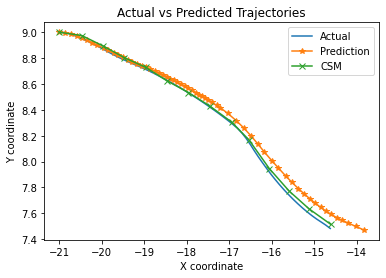

In [112]:
# Load data
traj_num = 11
# test_traj = TrajectoryLoad('./data/', traj_num , 6)
test_traj  =TrajectoryLoad2('./data/', traj_num, 100, 0.1, math.radians(10))
rel_traj_csm = pandas.read_csv('./data/traj_' + str(traj_num) + '/' + 'pose_list_CSM.csv', header=None).values
test_traj_csm  =TrajectoryLoad2('./data/', traj_num, 100, 0.498, math.radians(10))
print(len(test_traj))
# for i in range(len(test_traj)):
#     sample = test_traj[i]
#     print(sample['rel_pose'])

# Loading trained network parameters

device = torch.device("cuda")
net_x = Net()
net_x = net_x.to(device)
net_x = torch.load('./net_x_4.pyt')
net_y = Net()
net_y = net_y.to(device)
net_y = torch.load('./net_y_4.pyt')
net_angle = Net()
net_angle = net_angle.to(device)
net_angle = torch.load('./net_angle_4.pyt')

# Verifying results
abs_pose_act_array = []
abs_pose_pred_array = []
rel_pose_pred_array = []
rel_pose_act_array = []
abs_pose_pred_array.append(test_traj.getStartPose())
abs_pose_act_array.append(test_traj.getStartPose())
for i in range(len(test_traj)):
    inp = np.stack([test_traj[i]['image1'], test_traj[i]['image2']])
    inp = torch.tensor(np.expand_dims(inp, axis=0)).float().cuda()
    
#     print(net_x(inp).detach().cpu().numpy())
    rel_x = net_x(inp).detach().cpu().numpy()
    rel_y = net_y(inp).detach().cpu().numpy()
    rel_angle = net_angle(inp).detach().cpu().numpy()
    rel_pose_pred = np.array([rel_x, rel_y, rel_angle])
    rel_pose_act = test_traj[i]['rel_pose']
    
    rel_pose_pred_array.append(rel_pose_pred)
    rel_pose_act_array.append(rel_pose_act)
    
    abs_pose_pred_array.append(AbsolutePose(abs_pose_pred_array[-1], rel_pose_pred))
    abs_pose_act_array.append(AbsolutePose(abs_pose_act_array[-1], rel_pose_act))
    
rel_pose_pred_array = np.squeeze(np.asarray(rel_pose_pred_array))
rel_pose_act_array = np.asarray(rel_pose_act_array)
abs_pose_act_array = np.asarray(abs_pose_act_array)
abs_pose_pred_array = np.asarray(abs_pose_pred_array)

abs_traj_csm = []
for i in range(len(rel_traj_csm)):
    abs_traj_csm.append(AbsolutePose(test_traj.getStartPose(), rel_traj_csm[i]))
abs_traj_csm = np.asarray(abs_traj_csm)

abs_pose_act_array_csm = []
abs_pose_act_array_csm.append(test_traj_csm.getStartPose())
for i in range(len(test_traj_csm)):
    rel_pose_act = test_traj_csm[i]['rel_pose']
    abs_pose_act_array_csm.append(AbsolutePose(abs_pose_act_array_csm[-1], rel_pose_act))    
abs_pose_act_array_csm = np.asarray(abs_pose_act_array_csm)

# plt.figure()
# error_x = rel_pose_act_array[:,0]-rel_pose_pred_array[:,0]
# plt.plot(error_x, label='Error')
# # plt.plot(rel_pose_pred_array[:,0], label='Prediction')
# plt.xlabel("Number of pose pairs")
# plt.ylabel("Relative pose-X (m)")
# plt.title("Relative pose-X Error | MSE = " + "{:.5f}".format(np.mean(error_x**2)))
# plt.legend()
# plt.show()

# plt.figure()
# error_y = rel_pose_act_array[:,1]-rel_pose_pred_array[:,1]
# plt.plot(error_y, label='Error')
# # plt.plot(rel_pose_pred_array[:,0], label='Prediction')
# plt.xlabel("Number of pose pairs")
# plt.ylabel("Relative pose-Y (m)")
# plt.title("Relative pose-Y Error | MSE = " + "{:.5f}".format(np.mean(error_y**2)))
# plt.legend()
# plt.show()

# plt.figure()
# error_angle = rel_pose_act_array[:,2]-rel_pose_pred_array[:,2]
# plt.plot(np.degrees(error_angle), label='Error')
# # plt.plot(rel_pose_pred_array[:,0], label='Prediction')
# plt.xlabel("Number of pose pairs")
# plt.ylabel("Relative pose-Angle (deg)")
# plt.title("Relative pose-Angle Error | MSE (rad^2)= " + "{:.5f}".format(np.mean(error_angle**2)))
# plt.legend()
# plt.show()

plt.figure()
# dir = './data/' + 'traj_' + str(4) + '/'
# pose_list = pandas.read_csv(dir + 'pose_list.csv', header=None).values
# plt.plot(pose_list[:,0], pose_list[:,1], label='Raw')
plt.plot(abs_pose_act_array[:,0], abs_pose_act_array[:,1], label='Actual')
plt.plot(abs_pose_pred_array[:,0], abs_pose_pred_array[:,1], '-*', label='Prediction')
plt.plot(abs_traj_csm[:,0], abs_traj_csm[:,1], '-x', label='CSM')
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.title("Actual vs Predicted Trajectories")
plt.legend()
plt.show()

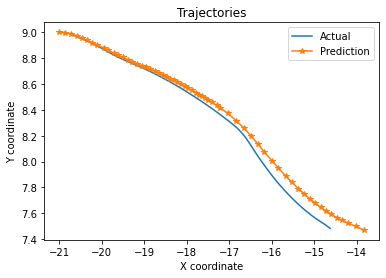

[-0.78932617  0.01121273 -0.08253865]
No of poses in array 1: 60
No of poses in array 2: 60
RMS Error (m) = 0.30
End of Trajectory Error (m) = 0.79
RMS Error (deg) = 2.1
End of Trajectory Error (deg) = 4.7


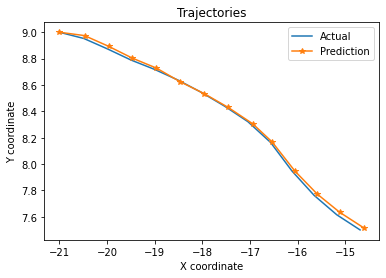

[-0.07778  -0.0155   -0.010153]
No of poses in array 1: 14
No of poses in array 2: 14
RMS Error (m) = 0.06
End of Trajectory Error (m) = 0.08
RMS Error (deg) = 0.6
End of Trajectory Error (deg) = 0.6


In [113]:
def TrajectoryError(pose_array_1, pose_array_2):
    plt.plot(pose_array_1[:,0], pose_array_1[:,1], label = 'Actual')
    plt.plot(pose_array_2[:,0], pose_array_2[:,1], '-*', label = 'Prediction')
    plt.xlabel("X coordinate")
    plt.ylabel("Y coordinate")
    plt.title("Trajectories")
    plt.legend()
    plt.show()
    
    pose_error = pose_array_1 - pose_array_2
    x_error = pose_error[:,0]
    y_error = pose_error[:,1]
    theta_error = np.absolute(np.degrees(pose_error[:,2]))
    dist_error = np.sqrt(x_error*x_error + y_error*y_error)
    rms_error = np.sqrt(np.mean(np.square(dist_error)))
    rms_theta_error = np.sqrt(np.mean(np.square(theta_error)))
    print(pose_error[-1])
    print('No of poses in array 1: ' + str(len(pose_array_1)))
    print('No of poses in array 2: ' + str(len(pose_array_2)))
    print('RMS Error (m) = ' + "{:.2f}".format(rms_error))
    print('End of Trajectory Error (m) = ' + "{:.2f}".format(dist_error[-1]))
    print('RMS Error (deg) = ' + "{:.1f}".format(rms_theta_error))
    print('End of Trajectory Error (deg) = ' + "{:.1f}".format(theta_error[-1]))
TrajectoryError(abs_pose_act_array, abs_pose_pred_array)
TrajectoryError(abs_pose_act_array_csm, abs_traj_csm)